# Set Up

## GPU & RAM

In [ ]:
'''Sie können jederzeit sehen, welche GPU Ihnen zugewiesen wurde, indem Sie die folgende Zelle ausführen.
Wenn das Ergebnis beim Ausführen der Codezelle unten „Not connected to a GPU“ lautet, dann können Sie die
Laufzeit im Menü unter Laufzeit > Laufzeittyp ändern ändern, um einen GPU-Beschleuniger zu aktivieren, und
dann die Codezelle noch einmal ausführen.'''

# Check GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

'''Um eine GPU mit Ihrem Notebook zu verwenden, wählen Sie die Menüoption Laufzeit > Laufzeittyp ändern und dann im Drop-down-Menü „Hardwarebeschleunigung“ die Option „GPU“ aus.'''

Fri Mar  1 10:42:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

'Um eine GPU mit Ihrem Notebook zu verwenden, wählen Sie die Menüoption Laufzeit > Laufzeittyp ändern und dann im Drop-down-Menü „Hardwarebeschleunigung“ die Option „GPU“ aus.'

In [ ]:
''' Nutzer, die eines der kostenpflichtigen Colab-Abos erworben haben, haben Zugriff auf VMs mit großem Arbeitsspeicher,
sobald diese verfügbar sind. Sie können jederzeit sehen, wie viel Speicher verfügbar ist, indem Sie die folgende Codezelle ausführen.
Wenn das Ergebnis beim Ausführen der Codezelle unten „Not using a high-RAM runtime“ lautet, dann können Sie die Laufzeit für erweiterten RAM im Menü
unter „Laufzeit“ > „Laufzeittyp ändern“ aktivieren. Wählen Sie dann im Drop-down-Menü „Laufzeitkonfiguration“ die Option „Erweiterter RAM“ aus.
Führen Sie anschließend die Codezelle noch einmal aus. '''

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Environment and Imports

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/My Drive/RecSys_Project
!pwd

Mounted at /content/drive
/content/drive/My Drive/RecSys_Project
/content/drive/My Drive/RecSys_Project


In [2]:
# Install libraries
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163007 sha256=e17272b45e1c7bdfa443492ee905104eb11274922c375a7c35e77ce992508158
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [20]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Surprise
from surprise import Dataset, Reader, KNNBasic, accuracy, dump, SVD, SVDpp, SlopeOne, AlgoBase
from surprise import NMF, NormalPredictor, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split, cross_validate, KFold

# Sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid

# Tensorflow
import tensorflow as tf

## Load Dataset

In [ ]:
# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train.csv')

# Load test dataset
test_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/test.csv')

In [ ]:
# Display the first few rows of each dataset to check if they loaded correctly
print("Train Dataset:")
train_data.head()

Train Dataset:


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


In [ ]:
print("\nTest Dataset:")
test_data.head()


Test Dataset:


,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30
1,1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28
2,2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27
3,3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30
4,4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29


# Data Preparation

In [ ]:
# Convert 'release_date' to datetime format (YYYYMMDD), handle errors by setting them to NaT
train_data['release_date'] = pd.to_datetime(train_data['release_date'], format='%Y%m%d', errors='coerce')
test_data['release_date'] = pd.to_datetime(test_data['release_date'], format='%Y%m%d', errors='coerce')

# Convert 'ts_listen' from UNIX timestamp to datetime object
train_data['ts_listen'] = pd.to_datetime(train_data['ts_listen'], unit='s')
test_data['ts_listen'] = pd.to_datetime(test_data['ts_listen'], unit='s')

# Display the updated dataset
print("Updated Train Dataset:")
train_data.head()

Updated Train Dataset:


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,2016-12-01 13:00:15,222606,41774,12,2004-07-04,1,0,223,0,0,9241,55164,29,0
1,25571,2016-11-30 22:25:35,250467,43941,0,2006-03-01,2,1,171,0,0,16547,55830,30,1
2,16,2016-11-19 13:59:13,305197,48078,1,2014-07-14,2,1,149,1,1,7665,2704,29,1
3,7,2016-11-26 09:21:38,900502,71521,0,2000-10-30,0,0,240,0,1,1580,938,30,0
4,7,2016-11-05 18:02:54,542335,71718,0,2008-02-15,0,0,150,0,1,1812,2939,24,1


In [ ]:
# @title Data Cleaning

# Check for missing values in each column
missing_values = train_data.isnull().sum()

# Display columns with missing values
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
release_date    17
dtype: int64


Since there are only 17 entries with missing values and our dataset is quite large we will simply drop the respective entries from our dataset.

In [ ]:
# Drop entries with missing values
train_data = train_data.dropna()

Next, we will extract the weekday and time of day from the timestamp (ts_listen).

In [ ]:
# Feature Engineering: Extract day of the week and hour of the day from 'ts_listen'
train_data['day_of_week'] = pd.to_datetime(train_data['ts_listen'], unit='s').dt.dayofweek
train_data['hour_of_day'] = pd.to_datetime(train_data['ts_listen'], unit='s').dt.hour

test_data['day_of_week'] = pd.to_datetime(test_data['ts_listen'], unit='s').dt.dayofweek
test_data['hour_of_day'] = pd.to_datetime(test_data['ts_listen'], unit='s').dt.hour

In [ ]:
train_data.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day
0,25471,2016-12-01 13:00:15,222606,41774,12,2004-07-04,1,0,223,0,0,9241,55164,29,0,3,13
1,25571,2016-11-30 22:25:35,250467,43941,0,2006-03-01,2,1,171,0,0,16547,55830,30,1,2,22
2,16,2016-11-19 13:59:13,305197,48078,1,2014-07-14,2,1,149,1,1,7665,2704,29,1,5,13
3,7,2016-11-26 09:21:38,900502,71521,0,2000-10-30,0,0,240,0,1,1580,938,30,0,5,9
4,7,2016-11-05 18:02:54,542335,71718,0,2008-02-15,0,0,150,0,1,1812,2939,24,1,5,18


It'd be valuable to see how many times a user has skipped a song recently. Hence, we will first sort the dataset ascendingly to ensure chronological order.

In [ ]:
# Sort the DataFrame by 'ts_listen'
train_data = train_data.sort_values(by='ts_listen')

In [ ]:
train_data.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day
5010516,0,1970-01-01 00:00:01,128809249,13615007,0,2016-10-21,1,0,454,0,0,4606,1690105,23,0,3,0
5321927,3,1970-01-01 00:00:02,6520974,601392,0,2009-03-09,1,2,467,0,0,13875,533184,28,0,3,0
824607,0,1970-01-01 00:00:02,124197688,13030394,0,2016-02-12,1,0,235,0,0,5034,66,19,1,3,0
1309460,7,1970-01-01 00:00:02,62723999,6157078,0,2012-12-05,1,0,213,0,0,7557,429675,28,1,3,0
5010515,0,1970-01-01 00:00:03,128809231,13615007,0,2016-10-21,1,0,388,0,0,4606,1690105,23,0,3,0


Uh-oh, it appears we have some missing data in the ts_listen column, with songs being listened to in 1970. Let's perform a quality check on this column.

In [ ]:
# Display unique years in the 'ts_listen' column
unique_years = train_data['ts_listen'].dt.year.unique()
print("Unique Years in 'ts_listen':", unique_years)

Unique Years in 'ts_listen': [1970 1980 1996 2001 2008 2009 2010 2011 2012 2013 2014 2015 2016]


It's safe to assume that everything before 2008 is a faulty entry - after all, Deezer was founded in 2007. So we will delete the respective entries from our dataset.

In [ ]:
# Filter out entries with incorrect timestamps (before 2007)
train_data = train_data[train_data['ts_listen'] >= '2007-01-01']
test_data = test_data[test_data['ts_listen'] >= '2007-01-01']

In [ ]:
train_data.head(10)

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day
261058,0,2008-12-31 23:01:31,132198352,14048082,2,2016-09-16,1,0,229,0,1,19655,17,23,1,2,23
1609482,0,2008-12-31 23:02:33,125599920,13211064,0,2016-06-24,1,0,195,0,0,11748,523462,21,1,2,23
4151949,782,2008-12-31 23:03:03,670673,81280,0,2005-05-17,1,0,125,0,1,3670,64431,28,1,2,23
4006205,0,2008-12-31 23:03:20,133120054,14170322,1,2016-09-30,1,0,198,1,0,42,1623794,30,1,2,23
1440265,108925,2008-12-31 23:05:09,1831862,189163,0,2003-12-31,1,0,170,0,1,3670,1319539,28,1,2,23
261059,0,2008-12-31 23:05:22,132198354,14048082,2,2016-09-16,1,0,509,0,1,19655,17,23,1,2,23
163339,0,2008-12-31 23:06:38,132123630,14038232,9,2016-09-16,1,0,252,0,0,19676,1519461,26,1,2,23
3849240,1130,2008-12-31 23:06:40,5639256,514869,1,2010-03-29,1,0,204,1,0,42,75001,30,1,2,23
1621487,50,2008-12-31 23:08:01,1642314,168483,0,2005-12-31,1,0,156,0,1,3670,316709,28,1,2,23
7360522,9,2008-12-31 23:10:38,3283973,313234,0,1995-12-31,1,0,151,0,1,3670,214795,28,1,2,23


In [ ]:
# Save cleaned and preprocessed datasets as csv, so we can load them more easily later on
train_data.to_csv('/content/drive/My Drive/RecSys_Project/train_data_clean.csv', index=False)
test_data.to_csv('/content/drive/My Drive/RecSys_Project/test_data_clean.csv', index=False)

In [ ]:
# @title Feature Engineering

# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean.csv')

# Sort the DataFrame based on 'ts_listen'
df_sorted = train_data.sort_values(by=['user_id', 'ts_listen'])

def create_listened_previous_song_column(group):
    # Shift the 'is_listened' column to get the previous song's status
    group['listened_previous_song'] = group['is_listened'].shift(fill_value=0)
    return group

# Apply the function to each group of users
df_sorted = df_sorted.groupby('user_id', group_keys=False).apply(create_listened_previous_song_column)

# Handle the special case for the very first song for each user
# You can choose to set it as 1 or any other value based on your preference
df_sorted['listened_previous_song'].fillna(1, inplace=True)

# Drop the temporary index created by groupby
df_sorted.reset_index(drop=True, inplace=True)

<ipython-input-56-c6c3e9e7faa1>:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_sorted = df_sorted.groupby('user_id').apply(create_listened_previous_song_column)


In [ ]:
# Assuming df_sorted is the DataFrame with the new 'listened_previous_song' column
last_entry_user_0 = df_sorted[df_sorted['user_id'] == 0].tail(1)
first_entry_user_1 = df_sorted[df_sorted['user_id'] == 1].head(1)

print("Last entry of user with user_id 0:")
last_entry_user_0

#print("\nFirst entry of user with user_id 1:")
#first_entry_user_1

Last entry of user with user_id 0:


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song
6316,77,2016-12-01 17:42:52,4602452,423257,1,2009-11-16,0,2,369,1,0,0,308848,26,1,3,17,1


In [ ]:
df_sorted[6310:6320]

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song
6310,50,2016-12-01 17:22:56,2466262,242347,1,2008-11-07,0,2,253,1,0,0,228,26,1,3,17,1
6311,9,2016-12-01 17:27:10,63022910,6187998,1,1998-04-11,0,2,289,1,0,0,9261,26,1,3,17,1
6312,0,2016-12-01 17:31:59,106061618,11056710,1,2015-09-04,0,2,214,1,0,0,7215914,26,0,3,17,1
6313,297,2016-12-01 17:32:05,70697364,6941024,1,2013-09-20,0,2,227,1,0,0,246791,26,1,3,17,0
6314,77,2016-12-01 17:35:53,4602458,423257,1,2009-11-16,0,2,247,1,0,0,308852,26,1,3,17,1
6315,0,2016-12-01 17:40:01,100557928,10321444,1,2014-11-24,0,2,170,1,0,0,2369,26,1,3,17,1
6316,77,2016-12-01 17:42:52,4602452,423257,1,2009-11-16,0,2,369,1,0,0,308848,26,1,3,17,1
6317,9,2016-10-31 23:09:04,87740665,8858933,6,2006-10-03,0,2,198,1,1,1,2918,27,1,0,23,0
6318,7,2016-11-01 09:10:05,2327111,231643,6,2004-06-14,0,2,104,1,1,1,3072,27,1,1,9,1
6319,0,2016-11-01 09:11:11,132625720,14101012,0,2016-09-23,0,2,187,0,1,1,5962948,27,1,1,9,1


In [ ]:
# Assuming df_sorted is the DataFrame with the new 'listened_previous_song' column
last_entry_user_4 = df_sorted[df_sorted['user_id'] == 4].tail(1)
first_entry_user_5 = df_sorted[df_sorted['user_id'] == 5].head(1)

print("Last entry of user with user_id 4:")
last_entry_user_4

#print("\nFirst entry of user with user_id 1:")
#first_entry_user_1

Last entry of user with user_id 0:


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song
29774,0,2016-12-01 05:49:29,130113321,13790715,0,2016-08-12,0,0,178,0,1,4,4328425,19,1,3,5,1


In [ ]:
df_sorted[29772:29778]

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song
29772,734,2016-11-30 16:43:56,82410902,8270494,1,2014-08-12,0,0,224,1,1,4,74804,19,1,2,16,0
29773,0,2016-12-01 05:47:39,136127850,14554310,0,2016-11-18,0,0,201,0,1,4,7459268,19,1,3,5,1
29774,0,2016-12-01 05:49:29,130113321,13790715,0,2016-08-12,0,0,178,0,1,4,4328425,19,1,3,5,1
29775,0,2016-11-02 08:58:19,131218578,13935646,0,2006-06-18,2,1,235,0,0,5,76,29,1,2,8,0
29776,9,2016-11-02 09:02:21,87112363,8790361,0,2014-09-15,2,1,389,0,0,5,6334,29,1,2,9,1
29777,253,2016-11-02 09:08:53,3855153,360029,0,2006-09-04,2,1,332,0,0,5,263798,29,1,2,9,1


Okay, it was implemented correctly.

In [ ]:
# Define a function to calculate the listened proportion over the prior 5 songs
def calculate_listened_proportion(group):
    # Calculate the sum of is_listened for the prior 5 songs
    group['listened_proportion_5'] = group['is_listened'].rolling(window=5, min_periods=1).sum()

    # Calculate the proportion based on the available entries
    group['listened_proportion_5'] = group['listened_proportion_5'] / group['is_listened'].rolling(window=5, min_periods=1).count()

    # Replace NaN values with 0
    group['listened_proportion_5'].fillna(0, inplace=True)

    return group

# Apply the function to each group of users
df_sorted = df_sorted.groupby('user_id', group_keys=False).apply(calculate_listened_proportion)

# Drop the temporary index created by groupby
df_sorted.reset_index(drop=True, inplace=True)

<ipython-input-68-a84a224c1762>:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_sorted = df_sorted.groupby('user_id').apply(calculate_listened_proportion)


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song,listened_proportion_5
29772,734,2016-11-30 16:43:56,82410902,8270494,1,2014-08-12,0,0,224,1,1,4,74804,19,1,2,16,0,0.4
29773,0,2016-12-01 05:47:39,136127850,14554310,0,2016-11-18,0,0,201,0,1,4,7459268,19,1,3,5,1,0.4
29774,0,2016-12-01 05:49:29,130113321,13790715,0,2016-08-12,0,0,178,0,1,4,4328425,19,1,3,5,1,0.6
29775,0,2016-11-02 08:58:19,131218578,13935646,0,2006-06-18,2,1,235,0,0,5,76,29,1,2,8,0,1.0
29776,9,2016-11-02 09:02:21,87112363,8790361,0,2014-09-15,2,1,389,0,0,5,6334,29,1,2,9,1,1.0
29777,253,2016-11-02 09:08:53,3855153,360029,0,2006-09-04,2,1,332,0,0,5,263798,29,1,2,9,1,1.0


In [ ]:
df_sorted[29768:29785]

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song,listened_proportion_5
29768,25521,2016-11-30 16:43:03,228670,42218,1,2005-05-23,0,0,212,1,1,4,16802,19,1,2,16,0,0.2
29769,27191,2016-11-30 16:43:51,17510064,1638342,1,2012-03-10,0,0,240,1,1,4,1634131,19,0,2,16,1,0.2
29770,64,2016-11-30 16:43:52,15165360,1397862,1,2010-02-28,0,0,281,1,1,4,72503,19,0,2,16,0,0.2
29771,0,2016-11-30 16:43:55,128118179,13529077,1,2016-07-06,0,0,206,1,1,4,523462,19,0,2,16,0,0.2
29772,734,2016-11-30 16:43:56,82410902,8270494,1,2014-08-12,0,0,224,1,1,4,74804,19,1,2,16,0,0.4
29773,0,2016-12-01 05:47:39,136127850,14554310,0,2016-11-18,0,0,201,0,1,4,7459268,19,1,3,5,1,0.4
29774,0,2016-12-01 05:49:29,130113321,13790715,0,2016-08-12,0,0,178,0,1,4,4328425,19,1,3,5,1,0.6
29775,0,2016-11-02 08:58:19,131218578,13935646,0,2006-06-18,2,1,235,0,0,5,76,29,1,2,8,0,1.0
29776,9,2016-11-02 09:02:21,87112363,8790361,0,2014-09-15,2,1,389,0,0,5,6334,29,1,2,9,1,1.0
29777,253,2016-11-02 09:08:53,3855153,360029,0,2006-09-04,2,1,332,0,0,5,263798,29,1,2,9,1,1.0


In [ ]:
def calculate_listening_prob(group):
    # Calculate the sum of is_listened for all songs
    total_sum = group['is_listened'].sum()

    # Calculate the total number of entries
    total_entries = group['is_listened'].count()

    # Calculate the overall proportion
    group['listening_prob'] = total_sum / total_entries if total_entries > 0 else 0

    return group

# Apply the function to each group of users
df_sorted = df_sorted.groupby('user_id', group_keys=False).apply(calculate_listening_prob)

# Drop the temporary index created by groupby
df_sorted.reset_index(drop=True, inplace=True)

<ipython-input-70-266f472f8b17>:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_sorted = df_sorted.groupby('user_id').apply(calculate_listening_prob)


In [ ]:
df_sorted[29772:29778]

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,listened_previous_song,listened_proportion_5,listening_prob
29772,734,2016-11-30 16:43:56,82410902,8270494,1,2014-08-12,0,0,224,1,1,4,74804,19,1,2,16,0,0.4,0.236454
29773,0,2016-12-01 05:47:39,136127850,14554310,0,2016-11-18,0,0,201,0,1,4,7459268,19,1,3,5,1,0.4,0.236454
29774,0,2016-12-01 05:49:29,130113321,13790715,0,2016-08-12,0,0,178,0,1,4,4328425,19,1,3,5,1,0.6,0.236454
29775,0,2016-11-02 08:58:19,131218578,13935646,0,2006-06-18,2,1,235,0,0,5,76,29,1,2,8,0,1.0,0.988704
29776,9,2016-11-02 09:02:21,87112363,8790361,0,2014-09-15,2,1,389,0,0,5,6334,29,1,2,9,1,1.0,0.988704
29777,253,2016-11-02 09:08:53,3855153,360029,0,2006-09-04,2,1,332,0,0,5,263798,29,1,2,9,1,1.0,0.988704


In [ ]:
# We'll save this new dataset as well
df_sorted.to_csv('/content/drive/My Drive/RecSys_Project/train_data_clean_2.csv', index=False)

# Exploratory Data Analysis (EDA)

## Basic Statistics
*   media_id - identifiant of the song listened by the user
*   album_id - identifiant of the album of the song
*   media_duration - duration of the song
*   user_gender -  gender of the user
*   user_id -  anonymized id of the user
*   context_type - type of content where the song was listened: playlist, album ...
*   release_date - release date of the song with the format YYYYMMDD
*   ts_listen - timestamp of the listening in UNIX time
*   platform_name - type of os
*   platform_family - type of device
*   user_age - age of the user
*   listen_type - if the songs was listened in a flow or not
*   artist_id - identifiant of the artist of the song
*   genre_id - identifiant of the genre of the song
*   is_listened - 1 if the track was listened, 0 otherwise

In [ ]:
# Display basic information about the dataset
print("Info about Train Dataset:")
train_data.info()

Info about Train Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7558186 entries, 682493 to 4791398
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   genre_id          int64         
 1   ts_listen         datetime64[ns]
 2   media_id          int64         
 3   album_id          int64         
 4   context_type      int64         
 5   release_date      datetime64[ns]
 6   platform_name     int64         
 7   platform_family   int64         
 8   media_duration    int64         
 9   listen_type       int64         
 10  user_gender       int64         
 11  user_id           int64         
 12  artist_id         int64         
 13  user_age          int64         
 14  is_listened       int64         
 15  day_of_week       int64         
 16  hour_of_day       int64         
 17  num_skips_last_5  int64         
dtypes: datetime64[ns](2), int64(16)
memory usage: 1.1 GB


In [ ]:
# Disable scientific notation for pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display summary statistics for 'user_age'
print("User Age:")
train_data['user_age'].describe()

User Age:


count   7558186.00
mean         24.31
std           3.77
min          18.00
25%          21.00
50%          25.00
75%          28.00
max          30.00
Name: user_age, dtype: float64

In [ ]:
train_data.describe()

,genre_id,media_id,album_id,context_type,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,day_of_week,hour_of_day,num_skips_last_5
count,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00,7558186.00
mean,2245.12,78398087.25,8136364.96,2.36,0.47,0.26,231.15,0.31,0.39,4037.20,1500743.68,24.31,0.68,2.92,13.50,3.41
std,13090.18,51335896.29,5460050.41,4.66,0.74,0.55,80.00,0.46,0.49,3954.78,2519556.46,3.77,0.46,1.90,5.50,1.76
min,0.00,200058.00,1976.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,18.00,0.00,0.00,0.00,0.00
25%,0.00,13766137.00,1256458.00,0.00,0.00,0.00,196.00,0.00,0.00,899.00,2605.00,21.00,0.00,1.00,10.00,2.00
50%,3.00,93816368.00,9527086.00,1.00,0.00,0.00,222.00,0.00,0.00,2737.00,194172.00,25.00,1.00,3.00,14.00,4.00
75%,27.00,126259195.00,13292847.00,2.00,1.00,0.00,254.00,1.00,1.00,6064.00,1519461.00,28.00,1.00,5.00,18.00,5.00
max,259731.00,137260128.00,14720858.00,73.00,2.00,2.00,65535.00,1.00,1.00,19917.00,11447410.00,30.00,1.00,6.00,23.00,5.00


## Plots

In this section we will explore the data and see how the different variables are distributed both across the train and the test dataset.

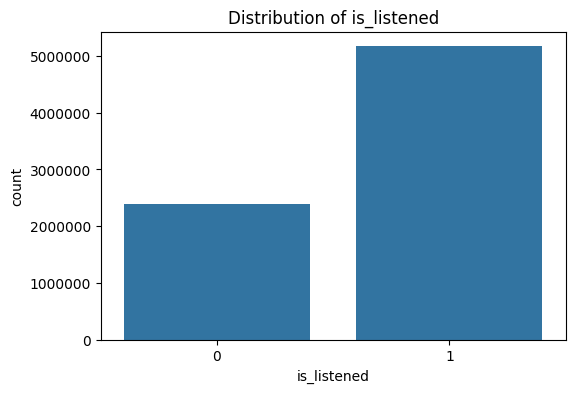

In [ ]:
# @title Distribution of 'is_listened' in train_data
# Visualize the distribution of the target variable 'is_listened'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_listened', data=train_data)

# Explicitly set the tick formatter for the y-axis to disable scientific notation
plt.ticklabel_format(style='plain', axis='y')

plt.title('Distribution of is_listened')
plt.show()

# @markdown We can see that surprisingly often, a song is skipped. Note that, since we aim to predict this exact variable in the test set, this variable does not exist in test_data.

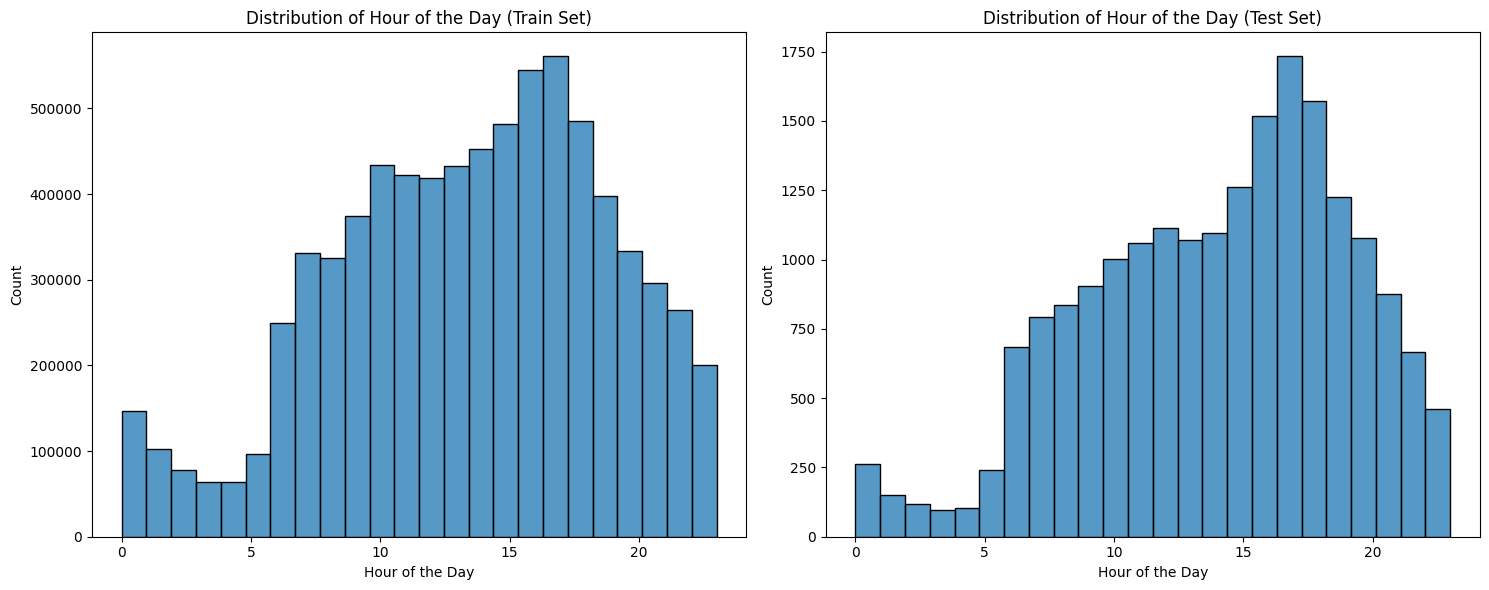

In [ ]:
# @title Distribution of 'hour_of_day' in both datasets

# @markdown The distribution looks fairly similar, so this is good.
# Set up a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for train_data
sns.histplot(train_data['hour_of_day'], bins=24, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Hour of the Day (Train Set)')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Count')

# Plot for test_data
sns.histplot(test_data['hour_of_day'], bins=24, kde=False, ax=axes[1])
axes[1].set_title('Distribution of Hour of the Day (Test Set)')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Count')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

In [ ]:
# TODO: plot train data ts listen binned by is_listened

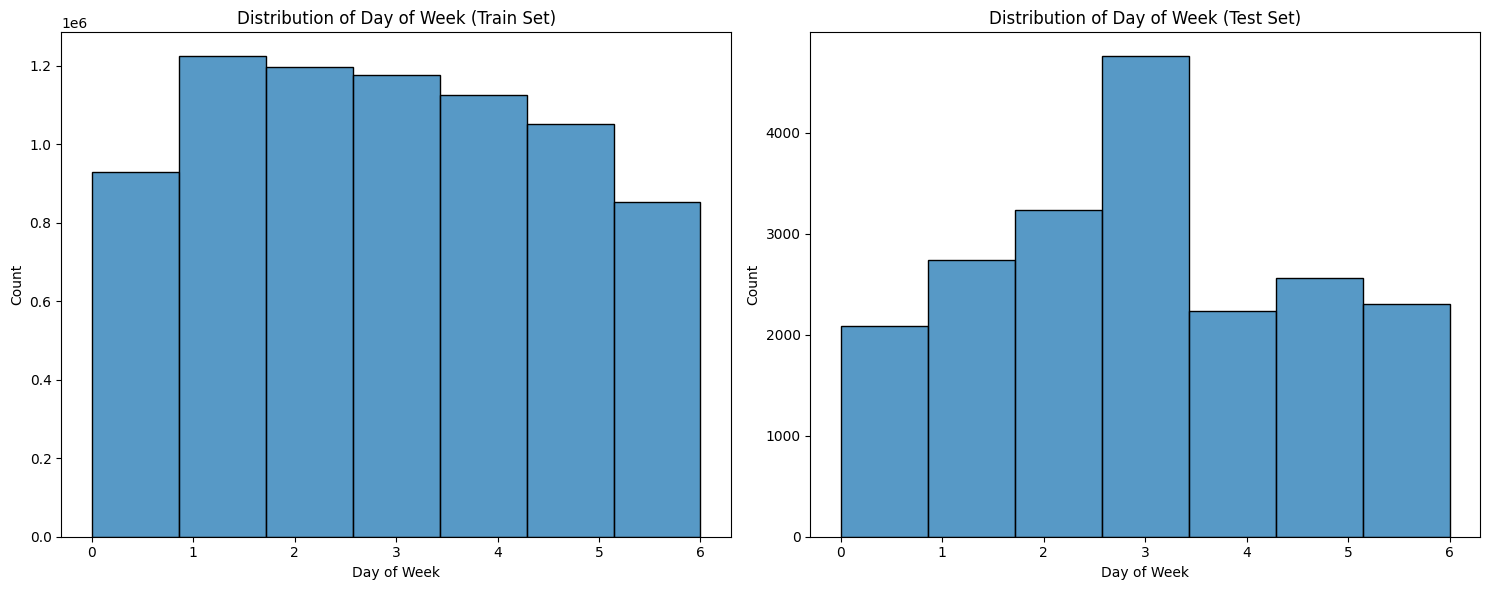

In [ ]:
# @title Distribution of 'day_of_week' in both datasets

# @markdown The distribution looks fairly similar, so this is good.
# Set up a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for train_data
sns.histplot(train_data['day_of_week'], bins=7, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Day of Week (Train Set)')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Count')

# Plot for test_data
sns.histplot(test_data['day_of_week'], bins=7, kde=False, ax=axes[1])
axes[1].set_title('Distribution of Day of Week (Test Set)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

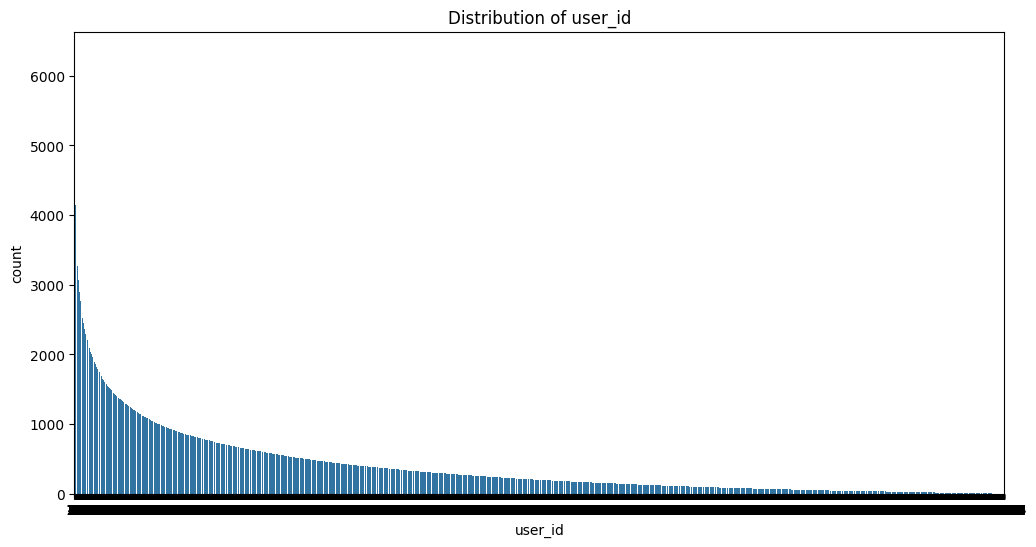

In [ ]:
# @title Number of songs per 'user_id' in train_data
# Plot number of songs per user_id of train
plt.figure(figsize=(12, 6))
sns.countplot(x='user_id', data=train_data)
plt.title('Distribution of user_id')
plt.show()

# @markdown We can see that the number of songs played per user differs heavily and those with a lot of songs played will be more robust. It is worth considering, whether we only want to consider those that have listened to a lot of songs for our model. In contrast, in the test_data, we have one song to predict per user.

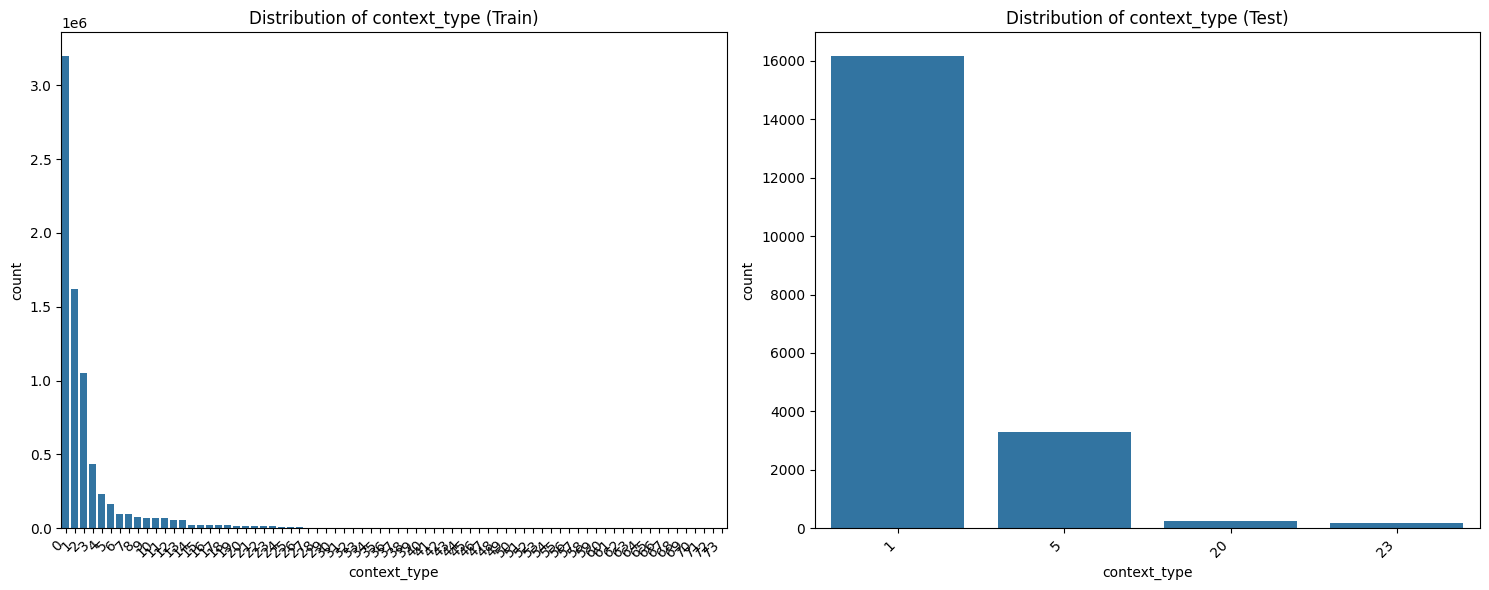

In [ ]:
# @title Distribution of 'context type'
# Visualize the distribution of 'context_type'

# Set plot style to avoid scientific notation
plt.rcParams['axes.formatter.useoffset'] = False

# Plot for train_data
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='context_type', data=train_data)
plt.title('Distribution of context_type (Train)')
plt.xticks(rotation=45, ha='right')

# Plot for test_data
plt.subplot(1, 2, 2)
sns.countplot(x='context_type', data=test_data)
plt.title('Distribution of context_type (Test)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# @markdown While in the train dataset there is an abundance of different contexts, there only exist 4 types of context in the test dataset.

We might consider limiting our model to the context types that are prevalent in the test-set.

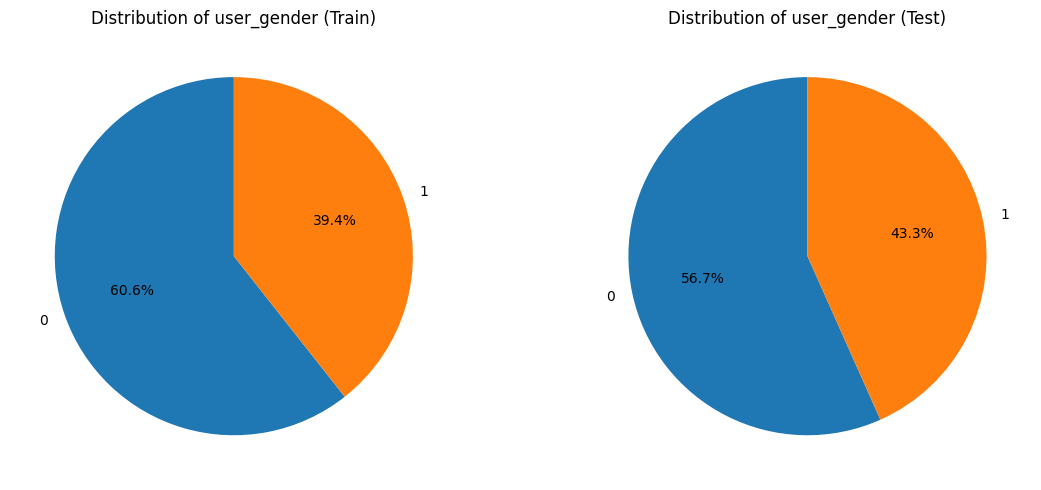

In [ ]:
# @title Distribution of 'user_gender'

# Set plot style to avoid scientific notation
plt.rcParams['axes.formatter.useoffset'] = False

# Set a smaller figure size
plt.figure(figsize=(12, 5))

# Plot for train_data
plt.subplot(1, 2, 1)
gender_counts_train = train_data['user_gender'].value_counts()
plt.pie(gender_counts_train, labels=gender_counts_train.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of user_gender (Train)')

# Plot for test_data
plt.subplot(1, 2, 2)
gender_counts_test = test_data['user_gender'].value_counts()
plt.pie(gender_counts_test, labels=gender_counts_test.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of user_gender (Test)')

plt.tight_layout()
plt.show()

# @markdown The distribution of gender is slightly different in the two datasets but should not pose a problem.

<ipython-input-31-3107d5e430f5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')


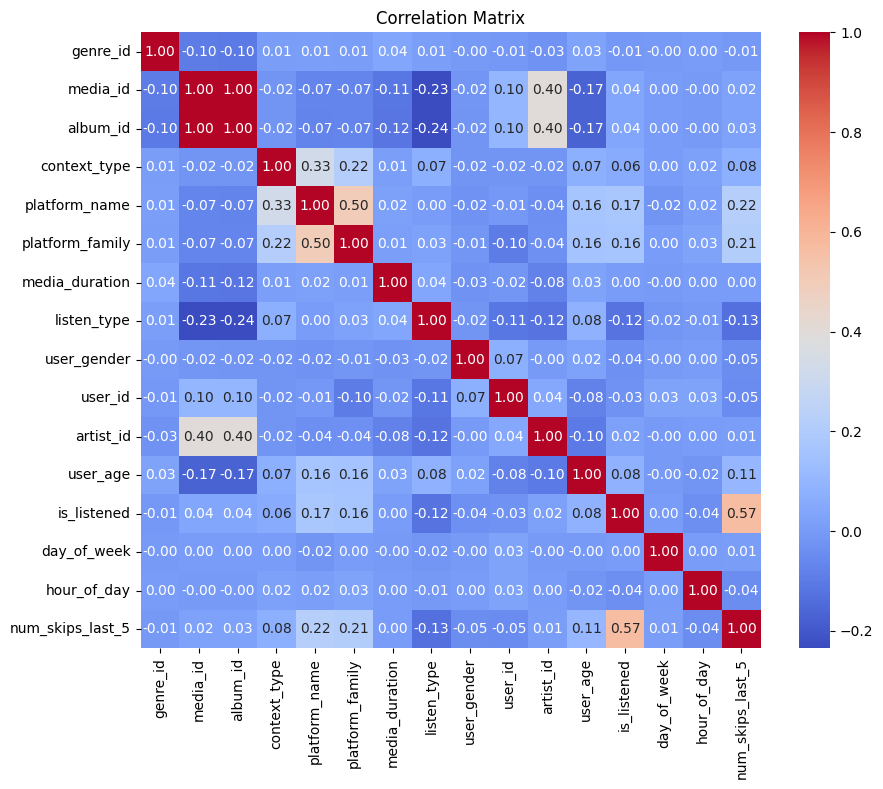

In [ ]:
# @title Correlation matrix
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

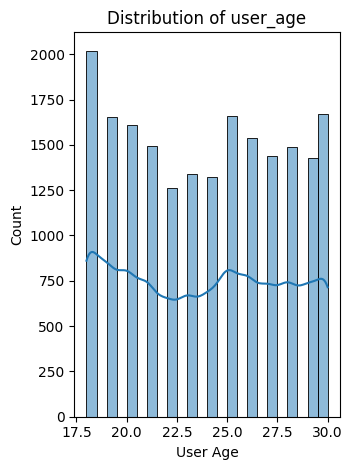

In [ ]:
# @title Distribution of 'user_age'

# Plot for test_data
plt.subplot(1, 2, 2)
sns.histplot(test_data['user_age'], kde=True)
plt.title('Distribution of user_age')
plt.xlabel('User Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

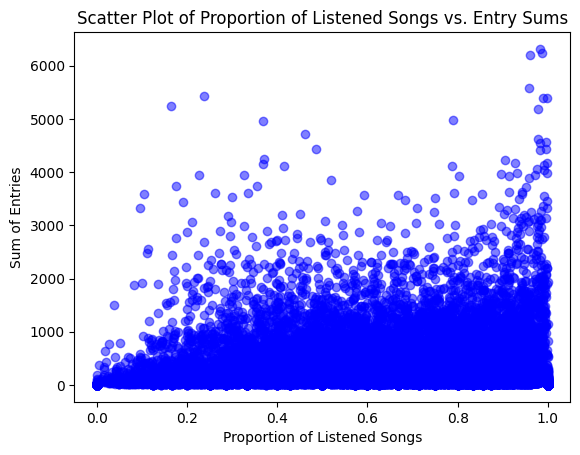

In [ ]:
# @title Listening and Skipping Frequency

# Calculate the sum of entries for each user
user_entry_sums = df_sorted.groupby('user_id').size().reset_index(name='entry_sums')

# Merge the user proportions and entry sums based on 'user_id'
merged_data = pd.merge(user_entry_sums, df_sorted[['user_id', 'listening_prob']].drop_duplicates(), on='user_id')

# Create a scatter plot
plt.scatter(merged_data['listening_prob'], merged_data['entry_sums'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Proportion of Listened Songs vs. Entry Sums')
plt.xlabel('Proportion of Listened Songs')
plt.ylabel('Sum of Entries')
plt.show()


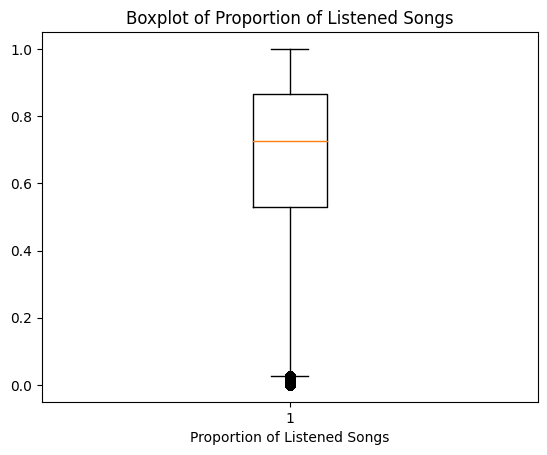

In [ ]:
# Create a boxplot
plt.boxplot(listening_probabilities, vert=True)
plt.title('Boxplot of Proportion of Listened Songs')
plt.xlabel('Proportion of Listened Songs')
plt.show()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7558186 entries, 682493 to 4791398
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   genre_id          int64         
 1   ts_listen         datetime64[ns]
 2   media_id          int64         
 3   album_id          int64         
 4   context_type      int64         
 5   release_date      datetime64[ns]
 6   platform_name     int64         
 7   platform_family   int64         
 8   media_duration    int64         
 9   listen_type       int64         
 10  user_gender       int64         
 11  user_id           int64         
 12  artist_id         int64         
 13  user_age          int64         
 14  is_listened       int64         
 15  day_of_week       int64         
 16  hour_of_day       int64         
 17  num_skips_last_5  int64         
dtypes: datetime64[ns](2), int64(16)
memory usage: 1.1 GB


# Train-Val Split
We'll need to split the training data set into a training and a validation set, in order to evaluate our models.

In [ ]:
# Extract features (X) and target variable (y)
X = train_data.drop(['is_listened', 'ts_listen', 'release_date'], axis=1)  # Exclude timestamp and release date
y = train_data['is_listened']

In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Recommender Models
In this section we will try a few different models and approaches to try and predict whether the next song will be listened by the user.

Using techniques like cross-validation and hyperparameter tuning will improve the models' robustness and be used occasionally, although not for all models as hyperparameter tuning is quite expensive and takes a lot of time.

## Getting Started: Overview over Different Models
Inspiration: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

Following the approach that the author of the above article took, we will start by comparing a bunch of models on a small fraction of our dataset to see what their general performance looks like. We will fit and predict the following models:

| Model          | Description                                                   | Advantages and Drawbacks                                                                                         |
|----------------|---------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| SVD            | Matrix factorization technique that decomposes the user-item matrix into user and item latent factors. | Effective for collaborative filtering, especially on dense datasets. Known for accuracy and capturing underlying patterns. |
| SVDpp          | Extension of SVD that takes into account implicit feedback and incorporates implicit ratings in addition to explicit ratings. | May provide better results than SVD when dealing with implicit feedback, capturing user preferences more comprehensively. |
| SlopeOne       | Simple item-based collaborative filtering algorithm that predicts user preferences based on the average difference in ratings between items. | Lightweight and efficient, suitable for small to medium-sized datasets. Does not require extensive computation. |
| NMF            | Similar to SVD, NMF factorizes the user-item matrix, but with the constraint that all factors must be non-negative. | Useful for scenarios where non-negativity is meaningful (e.g., when ratings are counts), but may be less interpretable compared to SVD. |
| NormalPredictor| Predicts ratings based on a normal distribution fitted to the training data. | Simple and fast, but may not perform well on datasets with complex patterns. Used as a baseline for comparison. |
| KNNBaseline    | K-nearest neighbors algorithm that incorporates baseline estimates into predictions. | Effective for collaborative filtering, especially when dealing with sparse and noisy datasets. Incorporating baseline estimates improves performance. |
| KNNBasic       | Basic k-nearest neighbors collaborative filtering algorithm that predicts ratings based on the weighted average of the k nearest neighbors. | Simple and intuitive but does not incorporate baseline estimates. May perform well on certain datasets. |
| KNNWithMeans   | K-nearest neighbors algorithm that takes into account mean ratings for users or items during prediction. | Useful for addressing user and item biases. Incorporating means can lead to more accurate predictions. |
| KNNWithZScore  | K-nearest neighbors algorithm that takes into account Z-score normalization during prediction. | Useful for handling variations in rating scales between users. May be effective in scenarios where normalization is crucial. |
| BaselineOnly   | Predicts ratings based on baseline estimates (global mean, user mean, item mean). | Simple baseline model often used for comparison. May perform well on certain datasets but lacks the sophistication of more advanced models. |
| CoClustering   | Collaborative filtering algorithm that clusters both users and items simultaneously. | Suitable for capturing user and item clusters, useful in scenarios where groups of users and items exhibit similar preferences. |


In [ ]:
# Load train dataset
train_data_reduced = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_reduced.csv')

In [ ]:
# Draw a sample of the train_data
subset_size = 0.05
data_subset = train_data_reduced.sample(frac=subset_size, random_state=42)

In [ ]:
# Create Traindata Object
reader = Reader(rating_scale=(0, 1))
data_subset = Dataset.load_from_df(data_subset[['user_id', 'media_id', 'is_listened']], reader)

In [ ]:
# Build the full trainset
trainset = data_subset.build_full_trainset()

# Print information about the trainset
print(f"Number of users in trainset: {trainset.n_users}")
print(f"Number of items in trainset: {trainset.n_items}")
print(f"Number of interactions in trainset: {trainset.n_ratings}")

Number of users in trainset: 15454
Number of items in trainset: 17533
Number of interactions in trainset: 279422


So we are cross-validating the models based on almost 300'000 interactions, which is still a fairly big amount of data.

The code is loosely taken from the blogpost, with a few modifications, given that we are dealing with a binary outcome and therefore the RMSE is not very useful. Hence, we have implemented the accuracy instead, applying a binary threshold to see whether the prediction leans towards (>= 0.5) the song being listened to (1) or whether it predicts the song not being listened (<0.5).

In [ ]:
threshold = 0.5    # for converting continuous predictions to binary (yes/no) predictions
results = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    try:
        print("Algorithm:", algorithm.__class__.__name__)

        # Cross-validate the algorithm
        kf = KFold(n_splits=3, random_state=42, shuffle=True)

        binary_predictions = []
        true_labels = []
        fit_times = []
        predict_times = []

        for trainset, testset in kf.split(data_subset):
          # Measure fit time
          start_time = time.time()
          algorithm.fit(trainset)
          fit_times.append(time.time() - start_time)

          # Make predictions on the test set
          start_time = time.time()
          predictions = algorithm.test(testset)
          predict_times.append(time.time() - start_time)

          # Convert continuous predictions to binary
          binary_predictions.extend([1 if pred.est >= threshold else 0 for pred in predictions])

          # Extract true labels from the testset
          true_labels.extend([test_tuple[2] for test_tuple in testset])

          # Calculate evaluation metric
          accuracy_score_value = accuracy_score(true_labels, binary_predictions)

        # Save results in a DataFrame
        result_dict = {
            'Algorithm': str(algorithm).split('.')[-1],
            'Accuracy': accuracy_score_value,
            'Fit Time': sum(fit_times) / len(fit_times),
            'Predict Time': sum(predict_times) / len(predict_times),
        }

        results.append(result_dict)
        print(result_dict)
        print("Done with", algorithm.__class__.__name__, ". Proceeding with the next model.")
        print("----------------------------------------------------------")

    except Exception as e:
        print(f"{algorithm.__class__.__name__} did not work: {e}")
        continue

# Create a DataFrame from the results list
df_results = pd.DataFrame(results).set_index('Algorithm')
print("All models in comparison:")
print(df_results)

Algorithm: SVD
{'Algorithm': 'SVD object at 0x7e45fa49ee00>', 'Accuracy': 0.719195338949689, 'Fit Time': 3.127641201019287, 'Predict Time': 0.6244091192881266}
Done with SVD . Proceeding with the next model.
----------------------------------------------------------
Algorithm: SVDpp
{'Algorithm': 'SVDpp object at 0x7e45fa49ee60>', 'Accuracy': 0.7271653627846054, 'Fit Time': 10.657285928726196, 'Predict Time': 4.4063206513722735}
Done with SVDpp . Proceeding with the next model.
----------------------------------------------------------
Algorithm: SlopeOne
{'Algorithm': 'SlopeOne object at 0x7e45fa49e440>', 'Accuracy': 0.6990609186105604, 'Fit Time': 7.178151369094849, 'Predict Time': 2.2772056261698403}
Done with SlopeOne . Proceeding with the next model.
----------------------------------------------------------
Algorithm: NMF
{'Algorithm': 'NMF object at 0x7e45fa49e2c0>', 'Accuracy': 0.685332579396039, 'Fit Time': 6.5599903265635175, 'Predict Time': 0.6182405153910319}
Done with NMF 

As we can see, the models perform all similarly, although the NormalPredictor as well as the KNNBasic perform worse than the others.

From that first glimpse, the BaselineOnly seems to work well - especially in light of computational costs with which the accuracy is achieved (in comparison to the SVDpp).

## Neighbourhood-Based Collaborative Filtering

In [ ]:
# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean.csv')

In [ ]:
# @title Baseline Model
# @markdown First, we will set up a baseline model against which we can later compare our model's performance. In our case of binary outcome variables, the baseline is simply the majority, which is that the user listens to the song and does not skip it, as we have earlier observed when plotting the distribution of the is_listened values. In other words, any model with an accuracy higher than 68% percent outperforms the baseline model.

# Set scale and load data
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_data[['user_id', 'media_id', 'is_listened']], reader)

# Split the dataset into train and test (i.e. validation) sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Compute the majority class in the training set
majority_class = trainset.global_mean > 0.5

# Create a baseline model that predicts the majority class for all items
class MajorityClassModel:
    def __init__(self, majority_class):
        self.majority_class = majority_class

    def predict(self, uid, iid):
        return int(self.majority_class)

# Instantiate the baseline model with the majority class
baseline_model = MajorityClassModel(majority_class)

# Make predictions on the test set
predictions = [baseline_model.predict(uid, iid) for uid, iid, _ in testset]

# Convert true labels from Surprise testset to a list
true_labels = [int(rating) for (_, _, rating) in testset]

# Evaluate the performance of the baseline model using accuracy
accuracy_value = accuracy_score(true_labels, predictions)
print(f"Baseline Model Accuracy: {accuracy_value}")

Baseline Model Accuracy: 0.6834718365111224


### User-Based Collaborative Filtering
Recommends items based on the preferences of users who are similar to the target user.

In [ ]:
# Create a Surprise dataset from DataFrame
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_data[['user_id', 'media_id', 'is_listened']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Build the user-based collaborative filtering model
sim_options = {'name': 'pearson', 'user_based': True}
model_KNN = KNNBasic(sim_options=sim_options, verbose=True)

In [ ]:
# Fit the model
model_KNN.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Make predictions on the validation set
predictions_KNN = model_KNN.test(testset)

We'll save the model and prediction for later use.

In [ ]:
# Save the model and predictions to a file
dump.dump("model_KNN.pkl", algo=model_KNN)
dump.dump("predictions_KNN.pkl", predictions_KNN)

In [ ]:
"""
# Load the model and predictions from the files
model_KNN, trainset = dump.load("model_KNN.pkl")
loaded_predictions = dump.load("predictions_KNN.pkl")
"""

Since we are interested in a binary outcome variable (yes or no), we need to convert the continuous predictions to binary values for estimation.

In [ ]:
# Convert continuous predictions to binary
threshold = 0.5
binary_predictions_KNN = [1 if pred[3] > threshold else 0 for pred in predictions_KNN]

# Extract true labels from the testset
true_labels = [test_tuple[2] for test_tuple in testset]

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions_KNN)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, binary_predictions_KNN)
precision = precision_score(true_labels, binary_predictions_KNN)
recall = recall_score(true_labels, binary_predictions_KNN)
f1 = f1_score(true_labels, binary_predictions_KNN)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[356153 121134]
 [ 64240 970111]]
Accuracy: 0.8774
Precision: 0.8890
Recall: 0.9379
F1 Score: 0.9128


**Confusion Matrix:**

*   True Positives (TP): 970,111
*   True Negatives (TN): 356,153
*   False Positives (FP): 121,134
*   False Negatives (FN): 64,240


**Accuracy:**
The ratio of correctly predicted instances (both positive and negative) to the total instances.
> Accuracy = (TP + TN) / (TP + TN + FP + FN) = 0.8774 = 87.74%



**Precision:**
The ratio of correctly predicted positive observations to the total predicted positives.
> Precision = TP / (TP + FP) = 0.8890 = 88.90%

**Recall (Sensitivity):**
The ratio of correctly predicted positive observations to all the actual positives.
> Recall = TP / (TP + FN) = 0.9379 = 93.79%

**F1 Score:**
F1 Score is the weighted average of precision and recall. It is a good way to show that a classifer has a good value for both precision and recall.
> F1 Score = 2 * (Precision * Recall) / (Precision + Recall) = 0.9128 (91.28%)

**Interpretation:**
The model has a high accuracy of 87.74%, indicating that it correctly predicts whether a user will listen to the next song or not in nearly 88% of the cases.
The precision of 88.90% suggests that when the model predicts a positive outcome (user will listen), it is correct about 89% of the time.
The recall of 93.79% indicates that the model captures 93.79% of all actual positive instances (users who actually listened to the next song).
The F1 score of 91.28% provides a balanced measure of precision and recall, considering both false positives and false negatives.
In summary, the model seems to perform well, especially in correctly identifying instances where users will listen to the next song. However, depending on the specific context and requirements, you might want to fine-tune the model further or consider other metrics that are more suitable for your use case.

### Item-Based Collaborative Filtering
Item-based collaborative filtering recommends items similar to those liked by the target user.

Using the surprise library, the item-based approach is very similar to the user-based approach: We only need to set the parameter 'user_based' to False instead of True. Then we can fit and evaluate the model as we did in the user-based approach.

In [ ]:
# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean.csv')

In [ ]:
# Create a Surprise dataset from DataFrame
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_data[['user_id', 'media_id', 'is_listened']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# For item-based collaborative filtering
sim_options_item = {'name': 'pearson', 'user_based': False}
model_KNN_item = KNNBasic(sim_options=sim_options_item)

In [ ]:
# Fit the model
# model_KNN_item.fit(trainset)

Applying an item-based approach without any further action lets the session crash due to RAM limitations (50.99 GB in CO Pro). Hence, we'll need to apply some dimensionality reduction in order to fit the model (or purchase more RAM, but I'll opt for the cheaper version here).

In [ ]:
# Print information about the trainset
print(f"Number of users in trainset: {trainset.n_users}")
print(f"Number of items in trainset: {trainset.n_items}")
print(f"Number of interactions in trainset: {trainset.n_ratings}")

Number of users in trainset: 19858
Number of items in trainset: 408577
Number of interactions in trainset: 6046548


As we have seen during EDA, the user-song interaction is long-tailed, with some users with an extensive listening history and others with only a handful of songs. By excluding some songs and users that have not (been) interacted (with) much, we can drastically reduce the dimension of the dataset.

Inspiration: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [ ]:
# Dimensionality reduction
min_listens = 50
filter_songs = train_data['media_id'].value_counts() > min_listens
filter_songs = filter_songs[filter_songs].index.tolist()

min_user_ratings = 50
filter_users = train_data['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

train_data_reduced = train_data[(train_data['media_id'].isin(filter_songs)) & (train_data['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train_data.shape))
print('The new data frame shape:\t{}'.format(train_data_reduced.shape))

The original data frame shape:	(7558186, 17)
The new data frame shape:	(5588444, 17)


In [ ]:
# Save reduced dataset
train_data_reduced.to_csv('/content/drive/My Drive/RecSys_Project/train_data_reduced.csv', index=False)

In [ ]:
# Create a Surprise dataset from DataFrame
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_data_reduced[['user_id', 'media_id', 'is_listened']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Fit the model
model_KNN_item.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


It worked! Let's save the model and carry on with the predictions.

In [ ]:
# Save the model and predictions to a file
dump.dump("model_KNN_item.pkl", algo=model_KNN_item)

In [ ]:
# Make predictions on the validation set
predictions_KNN_item = model_KNN_item.test(testset)

# Save predictions
dump.dump("predictions_KNN_item.pkl", predictions_KNN_item)

In [ ]:
# Convert continuous predictions to binary
threshold = 0.5
binary_predictions_KNN_item = [1 if pred[3] > threshold else 0 for pred in predictions_KNN_item]

# Extract true labels from the testset
true_labels = [test_tuple[2] for test_tuple in testset]

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions_KNN_item)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, binary_predictions_KNN_item)
precision = precision_score(true_labels, binary_predictions_KNN_item)
recall = recall_score(true_labels, binary_predictions_KNN_item)
f1 = f1_score(true_labels, binary_predictions_KNN_item)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[196957 166484]
 [110664 643584]]
Accuracy: 0.7520
Precision: 0.7945
Recall: 0.8533
F1 Score: 0.8228


**Confusion Matrix:**
*   True Positives (TP): 196,957
*   True Negatives (TN): 643,584
*   False Positives (FP): 166,484
*   False Negatives (FN): 110,664

**Accuracy:** 0.7520 = 75.20%

**Precision:** 0.7945 = 79.45%

**Recall (Sensitivity):** 0.8533 = 85.33%

**F1 Score:** 0.8228 = 82.28%

**Interpretation:**
The item-based collaborative filtering model achieved an accuracy of 75.20%, indicating that it correctly predicts whether a user will listen to the next song in approximately 75% of the cases. The precision of 79.45% suggests that when the model predicts a positive outcome (user will listen), it is correct about 79% of the time. The recall of 85.33% indicates that the model captures 85.33% of all actual positive instances (users who actually listened to the next song). The F1 score of 82.28% provides a balanced measure of precision and recall, considering both false positives and false negatives.

In summary, the item-based collaborative filtering model shows reasonable performance, with a balance between precision and recall.

However, it does perform worse than the user-based collaborative filtering model.

## Content-Based Filtering
Recommends items based on their features and the preferences expressed by the user in the past. It involves analyzing the content of the items and the user's profile.

### Principle Component Analysis
Since there are quite a few variables in the dataset, we'll start by checking which components have the biggest influence by conducting a Principal Components Analysis and fitting a model based on those features.

In [52]:
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean_2.csv')

# Extract relevant columns for content-based filtering
item_features = train_data[['genre_id', 'media_id', 'album_id', 'context_type',
                            'platform_name', 'platform_family', 'media_duration', 'listen_type', 'user_gender',
                            'user_id', 'artist_id', 'user_age', 'is_listened', 'day_of_week', 'hour_of_day',
                            'listened_previous_song', 'listened_proportion_5', 'listening_prob']]

# Standardize features
scaler = StandardScaler()
item_features_standardized = scaler.fit_transform(item_features.drop('is_listened', axis=1))

# Apply PCA
pca = PCA()  # No specific amount of components selected for now
item_features_pca = pca.fit_transform(item_features_standardized)

# Print the explained variance for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance and cumulative explained variance for each principal component
cumulative_explained_variance = explained_variance_ratio.cumsum()
for i, (explained_var, cumulative_var) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance), 1):
    print(f"Explained Variance for PCA Component {i}: {explained_var:.4f} | Cumulative Explained Variance: {cumulative_var:.4f}")

# Append the target variable 'is_listened' to the PCA features
item_features_pca = pd.DataFrame(item_features_pca, columns=[f'pca_{i}' for i in range(item_features_pca.shape[1])])
item_features_pca['is_listened'] = item_features['is_listened']


Explained Variance for PCA Component 1: 0.1594 | Cumulative Explained Variance: 0.1594
Explained Variance for PCA Component 2: 0.1454 | Cumulative Explained Variance: 0.3048
Explained Variance for PCA Component 3: 0.0828 | Cumulative Explained Variance: 0.3876
Explained Variance for PCA Component 4: 0.0648 | Cumulative Explained Variance: 0.4523
Explained Variance for PCA Component 5: 0.0604 | Cumulative Explained Variance: 0.5127
Explained Variance for PCA Component 6: 0.0588 | Cumulative Explained Variance: 0.5715
Explained Variance for PCA Component 7: 0.0581 | Cumulative Explained Variance: 0.6296
Explained Variance for PCA Component 8: 0.0569 | Cumulative Explained Variance: 0.6865
Explained Variance for PCA Component 9: 0.0549 | Cumulative Explained Variance: 0.7414
Explained Variance for PCA Component 10: 0.0512 | Cumulative Explained Variance: 0.7925
Explained Variance for PCA Component 11: 0.0501 | Cumulative Explained Variance: 0.8427
Explained Variance for PCA Component 12: 

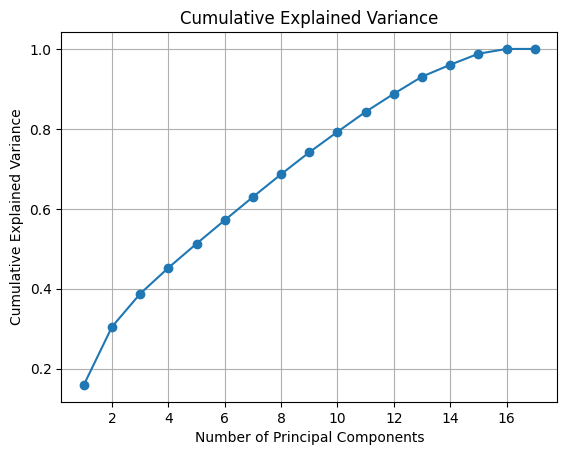

In [53]:
# Plot the cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Since the elbow appears to be at the second PC, we'll use only two PCs.

In [54]:
# Apply PCA
pca = PCA(2)  # The elbow appears to be at 2 PC
item_features_pca = pca.fit_transform(item_features_standardized)

# Print the explained variance for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance and cumulative explained variance for each principal component
cumulative_explained_variance = explained_variance_ratio.cumsum()
for i, (explained_var, cumulative_var) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance), 1):
    print(f"Explained Variance for PCA Component {i}: {explained_var:.4f} | Cumulative Explained Variance: {cumulative_var:.4f}")

# Append the target variable 'is_listened' to the PCA features
item_features_pca = pd.DataFrame(item_features_pca, columns=[f'pca_{i}' for i in range(item_features_pca.shape[1])])
item_features_pca['is_listened'] = item_features['is_listened']

Explained Variance for PCA Component 1: 0.1594 | Cumulative Explained Variance: 0.1594
Explained Variance for PCA Component 2: 0.1454 | Cumulative Explained Variance: 0.3048


In [55]:
# Get the principal component loadings
loadings = pd.DataFrame(pca.components_, columns=item_features.columns[:-1])

# Print the loadings for each principal component
for i in range(len(pca.explained_variance_ratio_)):
    print(f"Loadings for Principal Component {i + 1}:")
    print(loadings.iloc[i, :].sort_values(ascending=False))
    print()

Loadings for Principal Component 1:
listened_previous_song    0.453192
listened_proportion_5     0.443062
hour_of_day               0.409478
platform_name             0.357154
platform_family           0.341462
user_age                  0.215868
context_type              0.190927
media_duration            0.049607
genre_id                  0.032209
listen_type               0.000532
is_listened              -0.004545
day_of_week              -0.023476
user_gender              -0.047832
user_id                  -0.098673
artist_id                -0.121677
media_id                 -0.190275
album_id                 -0.190602
Name: 0, dtype: float64

Loadings for Principal Component 2:
listen_type               0.274330
user_age                  0.123023
media_duration            0.115220
genre_id                  0.093681
user_gender               0.028209
day_of_week               0.011689
context_type              0.000837
is_listened              -0.009487
platform_family          -0.

Let's fit a content-based model using the principal components obtained above.

In [44]:
# Split the data into train and test sets for the content-based model
item_train, item_test = sk_train_test_split(item_features, test_size=0.2, random_state=42)

In [45]:
# Define a simple RandomForestClassifier as a content-based model
class ContentBasedFiltering(AlgoBase):
    def __init__(self, model=None, **kwargs):
        AlgoBase.__init__(self, **kwargs)
        self.model = model

    def fit(self, trainset):
        # Extract features and labels
        X_train = trainset.drop('is_listened', axis=1)
        y_train = trainset['is_listened']

        # Fit the content-based model
        self.model.fit(X_train, y_train)
        return self

In [46]:
#  Instantiate the ContentBasedFiltering model with a RandomForestClassifier
content_model = ContentBasedFiltering(model=RandomForestClassifier(random_state=42))

In [48]:
# Fit the model on the training data
content_model.fit(item_train)

In [51]:
# Ground truth labels for the item_test dataset
y_true = item_test['is_listened']

# Extract features from the item_test dataset
X_test = item_test.drop('is_listened', axis=1)

# Use the previously obtained predictions from the model
y_pred = content_model.model.predict(X_test)

# Binary classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Print or use the metrics as needed
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

Accuracy: 0.8434
Precision: 0.8772
Recall: 0.8965
F1 Score: 0.8867
AUC-ROC Score: 0.8127


### Content-based filtering with RandomForest

Let's apply a Random Forest Classification without conducting PCA first.

In [ ]:
# Load train dataset
train_data_reduced = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_reduced.csv')

In [ ]:
# Draw a sample of the train_data
subset_size = 1  # adjust as needed (1 = full dataset, 0.05 = 5% sample)
data_subset = train_data_reduced.sample(frac=subset_size, random_state=42)

In [ ]:
# Feature selection
features = ['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration',
            'listen_type', 'user_gender', 'user_age', 'day_of_week', 'hour_of_day']

# Select features and target variable
X = data_subset[features]
y = data_subset['is_listened']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing pipeline
numeric_features = ['media_duration', 'user_age', 'hour_of_day']
categorical_features = ['genre_id', 'context_type', 'platform_name', 'platform_family',
                        'listen_type', 'user_gender', 'day_of_week']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

In [ ]:
# Model selection and training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.681513372682383
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47    363315
           1       0.75      0.80      0.77    754374

    accuracy                           0.68   1117689
   macro avg       0.63      0.62      0.62   1117689
weighted avg       0.67      0.68      0.67   1117689



**Accuracy:** The overall accuracy of the model on the test set is 0.6815 or 68.15%. This indicates the proportion of correctly predicted instances out of the total instances.

**Precision:**
* Precision for class 0 (Negative class): 0.51
Among the instances predicted as class 0, 51% were actually class 0.
* Precision for class 1 (Positive class): 0.75
Among the instances predicted as class 1, 75% were actually class 1.

**Recall (Sensitivity or True Positive Rate):**
* Recall for class 0 (Negative class): 0.43
Out of all actual class 0 instances, the model correctly identified 43% of them.
* Recall for class 1 (Positive class): 0.80
Out of all actual class 1 instances, the model correctly identified 80% of them.

**F1-Score:**
* F1-Score for class 0 (Negative class): 0.47
The harmonic mean of precision and recall for class 0.
* F1-Score for class 1 (Positive class): 0.77
The harmonic mean of precision and recall for class 1.

**Support:**
The number of actual instances of each class in the test set.

**Interpretation:**
* The model performs better in predicting class 1 (Positive class) as indicated by higher precision, recall, and F1-score for class 1 compared to class 0.
* The relatively lower precision and recall for class 0 suggest that the model is less effective at correctly identifying instances of class 0.
* The macro and weighted averages provide an overall summary across both classes, indicating that the model's performance is slightly better for class 1.

#### Hyperparameter Tuning
The model is obviously not especially good. Let's see what we can do adressing on the one hand the inherent class imbalance, and on the other using a grid search for hyperparameter tuning. Since training the model took 26 mins with the whole dataset, we'll use a small sample to try this out.

In [4]:
# Load train dataset
train_data_enhanced = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean_2.csv')

In [5]:
# Draw a sample of the train_data
subset_size = 0.05  # adjust as needed (1 = full dataset, 0.05 = 5% sample)
data_subset = train_data_enhanced.sample(frac=subset_size, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [7]:
# Feature selection
features = ['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration',
            'listen_type', 'user_gender', 'user_age', 'day_of_week', 'hour_of_day',
            'listened_previous_song', 'listened_proportion_5', 'listening_prob']

In [8]:
X = data_subset[features]
y = data_subset['is_listened']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Preprocessing pipeline
numeric_features = ['media_duration', 'user_age', 'hour_of_day', 'listened_previous_song', 'listened_proportion_5', 'listening_prob']
categorical_features = ['genre_id', 'context_type', 'platform_name', 'platform_family',
                        'listen_type', 'user_gender', 'day_of_week']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

In [10]:
from sklearn.metrics import make_scorer

# Custom scoring function with print statements
def custom_scorer(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Fitting model with accuracy: {accuracy:.4f}')
    return accuracy

In [ ]:
# Model selection and training with hyperparameter tuning using GridSearchCV
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(custom_scorer), verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting model with accuracy: 0.8424
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  19.0s
Fitting model with accuracy: 0.8405
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  18.9s
Fitting model with accuracy: 0.8423
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  18.7s
Fitting model with accuracy: 0.8436
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  38.4s
Fitting model with accuracy: 0.8421
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  38.2s
Fit

In [14]:
# Print details of the best model
print("Best Model Details:")
print("Classifier: ", best_model.named_steps['classifier'])  # Access the classifier part of the pipeline
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validated Accuracy: ", grid_search.best_score_)

Best Model Details:
Classifier:  RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=300,
                       random_state=42)
Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best Cross-Validated Accuracy:  0.8509428522911606


In [15]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Set class weights in the best model
best_model.set_params(classifier__class_weight={0: class_weights[0], 1: class_weights[1]})

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['media_duration', 'user_age',
                                                   'hour_of_day',
                                                   'listened_previous_song',
                                                   'listened_proportion_5',
                                                   'listening_prob']),
                                                 ('cat', 'passthrough',
                                                  ['genre_id', 'context_type',
                                                   'platform_name',
                                                   'platform_family',
                                                   'listen_type', 'user_gender',
                                                   'day_of_week'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1.58029899116617,
                                                      1: 0.7314174150344507},
                                        max_depth=10, min_samples_leaf=4,
                                        n_estimators=300, random_state=42))])

In [16]:
# Now we'll use the full dataset

# Draw a sample of the train_data
subset_size = 1  # adjust as needed (1 = full dataset, 0.05 = 5% sample)
data_subset = train_data_enhanced.sample(frac=subset_size, random_state=42)

X = data_subset[features]
y = data_subset['is_listened']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import joblib

In [18]:
# Fit the model on the training data
best_model.fit(X_train, y_train)

# Save model
try:
  joblib.dump(best_model, '/content/drive/My Drive/RecSys_Project/hypertuned_model.joblib')
except:
  print("saving model hasn't worked")

In [19]:
# Prediction and evaluation on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8260529306619706
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.89      0.76    478658
           1       0.94      0.80      0.86   1032980

    accuracy                           0.83   1511638
   macro avg       0.80      0.84      0.81   1511638
weighted avg       0.85      0.83      0.83   1511638



Our model's performance has significantly improved!

### Content-Based Filtering with Keras

In [ ]:
# Load train dataset
train_data_enhanced = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean_2.csv')

# Draw a sample of the train_data
subset_size = 1  # adjust as needed (1 = full dataset, 0.05 = 5% sample)
data_subset = train_data_enhanced.sample(frac=subset_size, random_state=42)

# Feature selection
features = ['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration',
            'listen_type', 'user_gender', 'user_age', 'day_of_week', 'hour_of_day',
            'listened_previous_song', 'listened_proportion_5', 'listening_prob']

# Select features and target variable
X = data_subset[features]
y = data_subset['is_listened']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Preprocessing pipeline
numeric_features = ['media_duration', 'user_age', 'hour_of_day', 'listened_previous_song',
                    'listened_proportion_5', 'listening_prob']
categorical_features = ['genre_id', 'context_type', 'platform_name', 'platform_family',
                        'listen_type', 'user_gender', 'day_of_week']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=64, validation_data=(X_test, y_test_one_hot))

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = tf.argmax(y_pred_prob, axis=1)

# Convert predictions to single-column format
y_test_single_col = tf.argmax(y_test_one_hot, axis=1)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test_single_col, y_pred)}')
print('Classification Report:')
print(classification_report(y_test_single_col, y_pred))


Epoch 1/10
94478/94478 [==============================] - 272s 3ms/step - loss: 1.0583 - accuracy: 0.8108 - val_loss: 0.3329 - val_accuracy: 0.8269
Epoch 2/10
94478/94478 [==============================] - 271s 3ms/step - loss: 0.3537 - accuracy: 0.8196 - val_loss: 0.3220 - val_accuracy: 0.8323
Epoch 3/10
94478/94478 [==============================] - 272s 3ms/step - loss: 0.3506 - accuracy: 0.8200 - val_loss: 0.3234 - val_accuracy: 0.8328
Epoch 4/10
94478/94478 [==============================] - 271s 3ms/step - loss: 0.3459 - accuracy: 0.8214 - val_loss: 0.3307 - val_accuracy: 0.8258
Epoch 5/10
94478/94478 [==============================] - 269s 3ms/step - loss: 0.3431 - accuracy: 0.8221 - val_loss: 0.3203 - val_accuracy: 0.8334
Epoch 6/10
94478/94478 [==============================] - 269s 3ms/step - loss: 0.3409 - accuracy: 0.8237 - val_loss: 0.3244 - val_accuracy: 0.8300
Epoch 7/10
94478/94478 [==============================] - 269s 3ms/step - loss: 0.3398 - accuracy: 0.8244 - val_

With an overall accuracy of 83.73% the model performs well!

In [ ]:
# Save the trained model
model.save('/content/drive/My Drive/RecSys_Project/tf_model.keras')

Using the keras library has a bunch of advantages over the previous approach with RandomForest, the most prominent one being that we can make use of Google Colab's GPU acceleration when using Tensorflow, thereby speeding up the process significantly.

## Model-Based Collaborative Filtering: Matrix Factorization Techniques

In this chapter, we will try two different matrix factorization models, as we have seen in the lecture: SVD and ALS.

In [56]:
# @title Singular Value Decomposition (SVD)
# @markdown A matrix factorization method that decomposes the user-item interaction matrix into the product of three matrices, capturing latent factors.

# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean.csv')

# Create a Surprise dataset from DataFrame
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_data[['user_id', 'media_id', 'is_listened']], reader)

# Use the SVD algorithm
model_SVD = SVD()

# Cross-validate the SVD model
kf = KFold(n_splits=3, random_state=42, shuffle=True)

accuracy_values = []
fit_times = []
predict_times = []

for fold, (trainset, testset) in enumerate(kf.split(data), start=1):
    print(f"Working on Fold {fold} ...")

    # Measure fit time
    start_time = time.time()
    print("fitting model ...")
    model_SVD.fit(trainset)
    fit_times.append(time.time() - start_time)

    # Make predictions on the test set
    start_time = time.time()
    print("predicting the future ...")
    predictions_SVD = model_SVD.test(testset)
    predict_times.append(time.time() - start_time)

    # Convert continuous predictions to binary
    binary_predictions = [1 if pred.est > 0.5 else 0 for pred in predictions_SVD]

    # Extract true labels from the testset
    true_labels = [test_tuple[2] for test_tuple in testset]

    # Calculate accuracy
    accuracy_values.append(accuracy_score(true_labels, binary_predictions))

# Calculate average fit and predict times
avg_fit_time = sum(fit_times) / len(fit_times)
avg_predict_time = sum(predict_times) / len(predict_times)

# Calculate average fit and predict times in minutes and seconds
avg_fit_time_minutes = avg_fit_time // 60
avg_fit_time_seconds = avg_fit_time % 60

avg_predict_time_minutes = avg_predict_time // 60
avg_predict_time_seconds = avg_predict_time % 60

# Print the accuracies for each fold
for fold, accuracy_value in enumerate(accuracy_values, start=1):
    print(f"Accuracy for Fold {fold}: {accuracy_value}")

# Print the average accuracy and times in minutes and seconds
avg_accuracy = sum(accuracy_values) / len(accuracy_values)
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Fit Time: {int(avg_fit_time_minutes)} mins {int(avg_fit_time_seconds)} secs")
print(f"Average Predict Time: {int(avg_predict_time_minutes)} mins {int(avg_predict_time_seconds)} secs")

Working on Fold 1 ...
fitting model ...
predicting the future ...
Working on Fold 2 ...
fitting model ...
predicting the future ...
Working on Fold 3 ...
fitting model ...
predicting the future ...
Accuracy for Fold 1: 0.7612991367772276
Accuracy for Fold 2: 0.761066446507991
Accuracy for Fold 3: 0.7609406226494853
Average Accuracy: 0.7611020686449012
Average Fit Time: 1 mins 37 secs
Average Predict Time: 0 mins 24 secs


In [57]:
# @title Alternating Least Squares (ALS)
# @markdown Another matrix factorization technique often used for collaborative filtering.

# Use the SVD algorithm with ALS
model_ALS = SVD(biased=False)

# Cross-validate the ALS model
kf = KFold(n_splits=3, random_state=42, shuffle=True)

accuracy_values = []
fit_times = []
predict_times = []

for fold, (trainset, testset) in enumerate(kf.split(data), start=1):
    print(f"Working on Fold {fold} ...")

    # Measure fit time
    start_time = time.time()
    print("fitting model ...")
    model_ALS.fit(trainset)
    fit_times.append(time.time() - start_time)

    # Make predictions on the test set
    start_time = time.time()
    print("predicting the future ...")
    predictions_ALS = model_ALS.test(testset)
    predict_times.append(time.time() - start_time)

    # Convert continuous predictions to binary
    binary_predictions = [1 if pred.est > 0.5 else 0 for pred in predictions_ALS]

    # Extract true labels from the testset
    true_labels = [test_tuple[2] for test_tuple in testset]

    # Calculate accuracy
    accuracy_values.append(accuracy_score(true_labels, binary_predictions))

# Calculate average fit and predict times
avg_fit_time = sum(fit_times) / len(fit_times)
avg_predict_time = sum(predict_times) / len(predict_times)

# Calculate average fit and predict times in minutes and seconds
avg_fit_time_minutes = avg_fit_time // 60
avg_fit_time_seconds = avg_fit_time % 60

avg_predict_time_minutes = avg_predict_time // 60
avg_predict_time_seconds = avg_predict_time % 60

# Print the accuracies for each fold
for fold, accuracy_value in enumerate(accuracy_values, start=1):
    print(f"Accuracy for Fold {fold}: {accuracy_value}")

# Print the average accuracy and times in minutes and seconds
avg_accuracy = sum(accuracy_values) / len(accuracy_values)
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Fit Time: {int(avg_fit_time_minutes)} mins {int(avg_fit_time_seconds)} secs")
print(f"Average Predict Time: {int(avg_predict_time_minutes)} mins {int(avg_predict_time_seconds)} secs")

Working on Fold 1 ...
fitting model ...
predicting the future ...
Working on Fold 2 ...
fitting model ...
predicting the future ...
Working on Fold 3 ...
fitting model ...
predicting the future ...
Accuracy for Fold 1: 0.714203721844442
Accuracy for Fold 2: 0.7124075422869379
Accuracy for Fold 3: 0.7130723844415028
Average Accuracy: 0.7132278828576276
Average Fit Time: 1 mins 40 secs
Average Predict Time: 0 mins 21 secs


Especially given the fact how fast matrix factorization techniques are in comparison to the collaborative and even more the content-based filtering models, they perform very well.

## Weighted Hybrid Model
Combine collaborative filtering and content-based filtering approaches to leverage the strengths of both.

While there are multiple approaches to hybrid models, we will simply use the weighted hybrid model, which combines predictions from different recommendation models using weighted averages or linear combinations.

This is a very easy to implement approach and there is high flexibility in adjusting the influence of each model.

In [ ]:
# Load train dataset
train_data = pd.read_csv('/content/drive/My Drive/RecSys_Project/train_data_clean_2.csv')

# Collaborative filtering data
reader = Reader(rating_scale=(0, 1))
data_collab = Dataset.load_from_df(train_data[['user_id', 'media_id', 'is_listened']], reader)
trainset_collab, testset_collab = train_test_split(data_collab, test_size=0.2, random_state=42)

# Load the KNN model from the saved file
loaded_model_KNN = dump.load("model_KNN.pkl")[1]

# Make predictions on the validation set
predictions_KNN = loaded_model_KNN.test(testset_collab)

In [59]:
# Content-based filtering data
subset_size = 1  # adjust as needed (1 = full dataset, 0.05 = 5% sample)
data_content = train_data.sample(frac=subset_size, random_state=42)

# Feature selection
features_content = ['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration',
                    'listen_type', 'user_gender', 'user_age', 'day_of_week', 'hour_of_day',
                    'listened_previous_song', 'listened_proportion_5', 'listening_prob']

# Select features and target variable
X_content = data_content[features_content]
y_content = data_content['is_listened']

# Train-test split for content-based filtering
X_train_content, X_test_content, y_train_content, y_test_content = sk_train_test_split(X_content, y_content, test_size=0.2, random_state=42)

# Preprocessing pipeline for content-based filtering
numeric_features_content = ['media_duration', 'user_age', 'hour_of_day', 'listened_previous_song',
                             'listened_proportion_5', 'listening_prob']
categorical_features_content = ['genre_id', 'context_type', 'platform_name', 'platform_family',
                                 'listen_type', 'user_gender', 'day_of_week']

numeric_transformer_content = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor_content = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_content, numeric_features_content),
        ('cat', 'passthrough', categorical_features_content)
    ])

# Convert labels to one-hot encoding for content-based filtering
y_train_one_hot_content = tf.keras.utils.to_categorical(y_train_content)
y_test_one_hot_content = tf.keras.utils.to_categorical(y_test_content)

# Load the Keras model from the saved file
loaded_model_content = tf.keras.models.load_model("tf_model.keras")

# Make predictions for content-based filtering
y_pred_prob_content = loaded_model_content.predict(X_test_content)
y_pred_content = np.argmax(y_pred_prob_content, axis=1)

# Evaluate the content-based model
print(f'Accuracy for Content-Based Filtering: {accuracy_score(y_test_content, y_pred_content)}')
print('Classification Report for Content-Based Filtering:')
print(classification_report(y_test_content, y_pred_content))

47239/47239 [==============================] - 61s 1ms/step
Accuracy for Content-Based Filtering: 0.8373188554402575
Classification Report for Content-Based Filtering:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72    478658
           1       0.85      0.92      0.89   1032980

    accuracy                           0.84   1511638
   macro avg       0.82      0.79      0.80   1511638
weighted avg       0.83      0.84      0.83   1511638



In [60]:
# Weight for combining predictions from collaborative and content-based models
collaborative_weight = 0.6
content_based_weight = 0.4

# Combine predictions from collaborative and content-based models
predictions_hybrid = [(pred_KNN.est * collaborative_weight + pred_content[1] * content_based_weight) for pred_KNN, pred_content in zip(predictions_KNN, y_pred_prob_content)]

# Convert continuous predictions to binary
threshold_hybrid = 0.5
binary_predictions_hybrid = [1 if pred > threshold_hybrid else 0 for pred in predictions_hybrid]

# Extract true labels from the testset for hybrid model
true_labels_hybrid = [test_tuple[2] for test_tuple in testset_collab]

# Compute confusion matrix for hybrid model
cm_hybrid = confusion_matrix(true_labels_hybrid, binary_predictions_hybrid)

# Calculate evaluation metrics for hybrid model
accuracy_hybrid = accuracy_score(true_labels_hybrid, binary_predictions_hybrid)
precision_hybrid = precision_score(true_labels_hybrid, binary_predictions_hybrid)
recall_hybrid = recall_score(true_labels_hybrid, binary_predictions_hybrid)
f1_hybrid = f1_score(true_labels_hybrid, binary_predictions_hybrid)

print(f"Confusion Matrix for Hybrid Model:\n{cm_hybrid}")
print(f"Accuracy for Hybrid Model: {accuracy_hybrid:.4f}")
print(f"Precision for Hybrid Model: {precision_hybrid:.4f}")
print(f"Recall for Hybrid Model: {recall_hybrid:.4f}")
print(f"F1 Score for Hybrid Model: {f1_hybrid:.4f}")

Confusion Matrix for Hybrid Model:
[[248788 228499]
 [ 70883 963468]]
Accuracy for Hybrid Model: 0.8019
Precision for Hybrid Model: 0.8083
Recall for Hybrid Model: 0.9315
F1 Score for Hybrid Model: 0.8655


The model performs alright. However, we have set the weights arbitrarily. Let's see whether we can increase performance by searching for optimal weights through a parameter grid search.

In [62]:
# Define the parameter grid for grid search
param_grid = {
    'collaborative_weight': np.arange(0.1, 1.0, 0.1),
}

best_accuracy = 0.0
best_params = {}

# Grid search
for params in ParameterGrid(param_grid):
    collaborative_weight = params['collaborative_weight']
    content_based_weight = 1 - collaborative_weight

    # Combine predictions from collaborative and content-based models
    predictions_hybrid = [(pred_KNN.est * collaborative_weight + pred_content[1] * content_based_weight) for pred_KNN, pred_content in zip(predictions_KNN, y_pred_prob_content)]

    # Convert continuous predictions to binary
    threshold_hybrid = 0.5
    binary_predictions_hybrid = [1 if pred > threshold_hybrid else 0 for pred in predictions_hybrid]

    # Extract true labels from the testset for hybrid model
    true_labels_hybrid = [test_tuple[2] for test_tuple in testset_collab]

    # Calculate accuracy for the hybrid model
    accuracy_hybrid = accuracy_score(true_labels_hybrid, binary_predictions_hybrid)

    # Update best parameters if the current configuration has better accuracy
    if accuracy_hybrid > best_accuracy:
        best_accuracy = accuracy_hybrid
        best_params = params

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'collaborative_weight': 0.9}
Best Accuracy: 0.8727314343778074


Increasing the influence of the collaborative model increased the model's performance significantly.

# Conclusion: Results per Model

As the accuracy scores of the different approaches show, using either a user-based collaborative filtering model or a hybrid model (predominantly using the collaborative model) results in the best predictions:

* Baseline Model: 0.6835
* User-Based Collaborative Filtering: 0.8774
* Item-Based Collaborative Filtering: 0.7520
* Content-Based Filtering w/ PC: 0.8434
* Content-Based Filtering w/o PC: 0.6815 w/o tuning and 0.8261 w/ tuning and additional listening history features
* Content-Based Filtering using Keras: 0.8373
* Model-Based Collaborative Filtering, SVD: 0.7611
* Model-Based Collaborative Filtering, ALS: 0.7132
* Weighted Hybrid Model: 0.8727

It must be noted that for models using features, not always the same dataset was used, as the additional feature engineering of the listening histories was only done at a later stage and (out of time constraints given the lengthy fitting processes) the previously fitted models were not fitted again. For instance, the fitting using PCA or the keras model relied on a dataset which included the feature engineered listening histories, while the untuned content-based filtering model did not have the dataset with the listening history.

Further, we did also not hypertune and cross-validate for all models. This was done primarily for the content-based filtering models as - again - the computational costs are high to finetune so many models. Hence, this would be an area to further invest energy and time into to make the models more robust and improve their performance.

Since we do not have the results to the Deezer challenge, we will refrain from fitting the testset here.